# Temporal Fusion Transformer Tutorial for Time Series Forecasting using Pytorch Lightning

In [1]:
mat_filepath = "../gps_datasets/test_transformer/smooth_data_full.mat"
csv_filepath = "../gps_datasets/test_transformer/combined_data.csv"

In [2]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

import warnings
warnings.filterwarnings("ignore")

import os
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

from scipy.io import loadmat
from pathlib import Path

import torch

import lightning.pytorch as pl 
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor 
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.tuner import Tuner

from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import (
    optimize_hyperparameters,
)

## Converting .mat file to .csv

In [3]:
mat = loadmat(mat_filepath)

In [4]:
print(mat.keys())

dict_keys(['__header__', '__version__', '__globals__', 'original_correction_value', 'processed_broadcast_clock_bias', 'processed_correction_value', 'None', 'processed_final_clock_bias', '__function_workspace__'])


In [5]:
mat = {k: v for k, v in mat.items() if not k.startswith('__') and not k.endswith('__') and k != "None"}

In [6]:
print(mat)

{'original_correction_value': array([[ 3.77025300e-10,  2.07725515e-10,  1.66652731e-10, ...,
        -4.01776400e-10, -1.93164357e-10, -3.62395213e-10]]), 'processed_broadcast_clock_bias': array([[-4.46614809e-04, -4.46614687e-04, -4.46614564e-04, ...,
        -6.26967326e-05, -6.26965621e-05, -6.26963915e-05]]), 'processed_correction_value': array([[4.17033936e-10, 4.17040428e-10, 4.17053207e-10, ...,
        1.30038358e-09, 1.30044855e-09, 1.30050543e-09]]), 'processed_final_clock_bias': array([[-4.46614432e-04, -4.46614479e-04, -4.46614397e-04, ...,
        -6.26971344e-05, -6.26967552e-05, -6.26967539e-05]])}


In [7]:
data = pd.DataFrame({k: pd.Series(v[0]) for k, v in mat.items()})

In [8]:
data.to_csv(csv_filepath, index = False)

## Convert CSV to Pandas DataFrame

In [9]:
df = pd.read_csv(csv_filepath)

In [10]:
display(df)

,original_correction_value,processed_broadcast_clock_bias,processed_correction_value,processed_final_clock_bias
0,3.770253e-10,-0.000447,4.170339e-10,-0.000447
1,2.077255e-10,-0.000447,4.170404e-10,-0.000447
2,1.666527e-10,-0.000447,4.170532e-10,-0.000447
3,1.995279e-10,-0.000447,4.170637e-10,-0.000447
4,1.381092e-10,-0.000447,4.170739e-10,-0.000447
...,...,...,...,...
2100715,-3.507794e-10,-0.000063,1.300274e-09,-0.000063
2100716,-3.300659e-10,-0.000063,1.300327e-09,-0.000063
2100717,-4.017764e-10,-0.000063,1.300384e-09,-0.000063
2100718,-1.931644e-10,-0.000063,1.300449e-09,-0.000063


In [11]:
df.describe()

,original_correction_value,processed_broadcast_clock_bias,processed_correction_value,processed_final_clock_bias
count,2.100720e+06,2.100720e+06,2.100720e+06,2.100720e+06
mean,1.489596e-09,-2.675219e-04,1.489886e-09,-2.675205e-04
std,9.923194e-10,1.165445e-04,3.113392e-10,1.165444e-04
min,-1.412022e-09,-4.466148e-04,4.114572e-10,-4.466145e-04
25%,8.530563e-10,-3.733339e-04,1.348769e-09,-3.733313e-04
50%,1.511792e-09,-2.774303e-04,1.503959e-09,-2.774293e-04
75%,2.145862e-09,-1.624731e-04,1.660942e-09,-1.624717e-04
max,4.312638e-09,-6.269639e-05,2.751367e-09,-6.269675e-05


## Plot DataFrame Info

Text(0.5, 1.0, 'Plot')

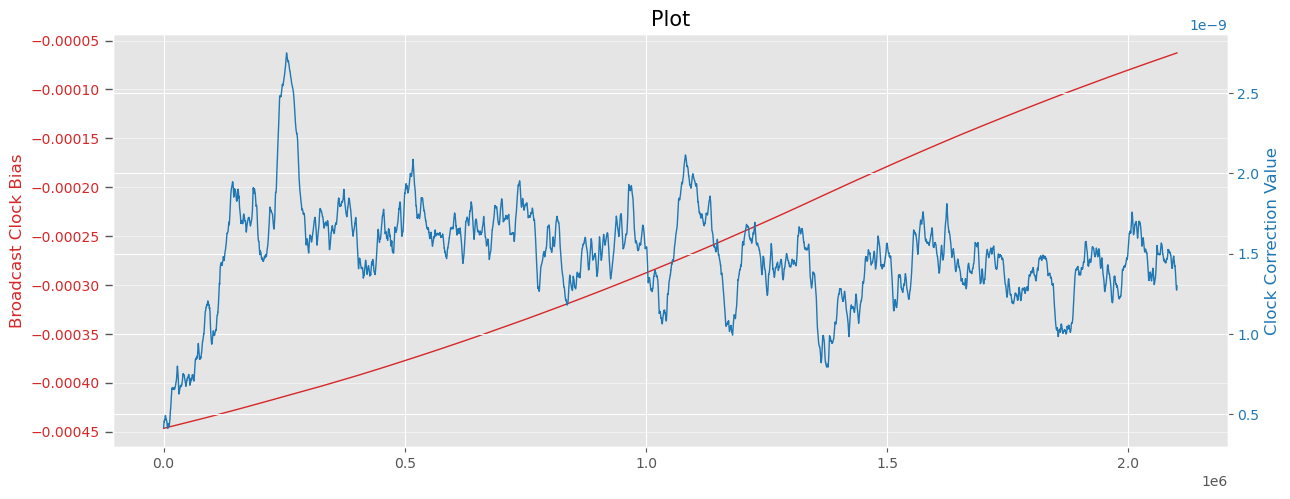

In [17]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [13,5]

data_ax1 = df.processed_broadcast_clock_bias
data_ax2 = df.processed_correction_value
fig, ax1 = plt.subplots()
        
ax1.set_ylabel('Broadcast Clock Bias', color = 'tab:red')
ax1.plot(data_ax1, color = 'tab:red', linewidth= 1)
ax1.tick_params(axis = 'y',
                labelcolor= 'tab:red',
                length = 6, 
                width = 1, 
                grid_alpha=0.5)
    
ax2 = ax1.twinx()
ax2.set_ylabel('Clock Correction Value', color = 'tab:blue')
ax2.plot(data_ax2, color = 'tab:blue', linewidth = 1)
ax2.tick_params(axis='y', labelcolor = 'tab:blue')
fig.tight_layout()
plt.title("Plot", fontsize = 15)

## Implementing Toy Transformer

In [18]:
data = df

In [19]:
data['time_idx'] = range(len(df))
data['satellite_id'] = 0

In [20]:
data.sample(100, random_state=0)

,original_correction_value,processed_broadcast_clock_bias,processed_correction_value,processed_final_clock_bias,time_idx,satellite_id
1548236,1.605602e-10,-0.000168,1.283278e-09,-0.000168,1548236,0
1402147,5.085995e-10,-0.000201,1.280398e-09,-0.000201,1402147,0
461863,2.981507e-09,-0.000383,1.611610e-09,-0.000383,461863,0
1842982,1.212947e-09,-0.000109,1.306207e-09,-0.000109,1842982,0
1724641,2.947033e-09,-0.000132,1.416555e-09,-0.000132,1724641,0
...,...,...,...,...,...,...
1684876,-7.847669e-10,-0.000140,1.553641e-09,-0.000140,1684876,0
1277503,2.498069e-09,-0.000229,1.427550e-09,-0.000229,1277503,0
602090,1.419363e-10,-0.000361,1.729017e-09,-0.000361,602090,0
1150588,1.530716e-09,-0.000256,1.495353e-09,-0.000256,1150588,0


In [21]:
data.describe()

,original_correction_value,processed_broadcast_clock_bias,processed_correction_value,processed_final_clock_bias,time_idx,satellite_id
count,2.100720e+06,2.100720e+06,2.100720e+06,2.100720e+06,2.100720e+06,2100720.0
mean,1.489596e-09,-2.675219e-04,1.489886e-09,-2.675205e-04,1.050360e+06,0.0
std,9.923194e-10,1.165445e-04,3.113392e-10,1.165444e-04,6.064258e+05,0.0
min,-1.412022e-09,-4.466148e-04,4.114572e-10,-4.466145e-04,0.000000e+00,0.0
25%,8.530563e-10,-3.733339e-04,1.348769e-09,-3.733313e-04,5.251798e+05,0.0
50%,1.511792e-09,-2.774303e-04,1.503959e-09,-2.774293e-04,1.050360e+06,0.0
75%,2.145862e-09,-1.624731e-04,1.660942e-09,-1.624717e-04,1.575539e+06,0.0
max,4.312638e-09,-6.269639e-05,2.751367e-09,-6.269675e-05,2.100719e+06,0.0


In [22]:
max_prediction_length = 120 # the length of the forecasting 
max_encoder_length = 240 # how much past data is used to create predictions
training_cutoff = data["time_idx"].max() - max_prediction_length

In [23]:
training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="processed_correction_value",
    group_ids=["satellite_id"],
    min_encoder_length=max_encoder_length
    // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=[],
    static_reals=[],
    time_varying_known_categoricals=[],
    time_varying_known_reals=["time_idx"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        "processed_broadcast_clock_bias",
        "processed_final_clock_bias",
        "processed_correction_value",
    ],
    target_normalizer=GroupNormalizer(
        groups=["satellite_id"], transformation="softplus"
    ),  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

In [24]:
validation = TimeSeriesDataSet.from_dataset(
    training, data, predict=True, stop_randomization=True
)


In [25]:
# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(
    train=True, batch_size=batch_size, num_workers=0
)
val_dataloader = validation.to_dataloader(
    train=False, batch_size=batch_size * 10, num_workers=0
)

In [26]:
baseline_predictions = Baseline().predict(val_dataloader, return_y=True)
MAE()(baseline_predictions.output, baseline_predictions.y)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


tensor(4.0407e-12, device='mps:0')

In [27]:
# configure network and trainer
pl.seed_everything(42) # https://pytorch-lightning.readthedocs.io/en/1.7.7/api/pytorch_lightning.utilities.seed.html

trainer = pl.Trainer(
    accelerator="cpu",
    gradient_clip_val=0.1,
)


Seed set to 42
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [28]:
tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=8,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    loss=QuantileLoss(), # suitable for probabilistic forecasting 
    optimizer="ranger", # combines the RAdam+ Lookahead - this often leads to a fast convergence
    # reduce learning rate if no improvement in validation loss after x epochs
    # reduce_on_plateau_patience=1000,
)
print(f"Number of parameters in network: {tft.size() / 1e3:.1f}k")


Number of parameters in network: 7.6k


Finding best initial lr:  73%|███████▎  | 73/100 [03:53<01:26,  3.20s/it]
LR finder stopped early after 73 steps due to diverging loss.
Learning rate set to 0.000331131121482591
Restoring states from the checkpoint path at /Users/marilyn/Library/Mobile Documents/com~apple~CloudDocs/Documents/doctorate/ssdl/gps_clock_drift_estimation/.lr_find_f9ad79d6-50e3-42f0-8ce1-b6a47b912c2f.ckpt
Restored all states from the checkpoint at /Users/marilyn/Library/Mobile Documents/com~apple~CloudDocs/Documents/doctorate/ssdl/gps_clock_drift_estimation/.lr_find_f9ad79d6-50e3-42f0-8ce1-b6a47b912c2f.ckpt


suggested learning rate: 0.000331131121482591


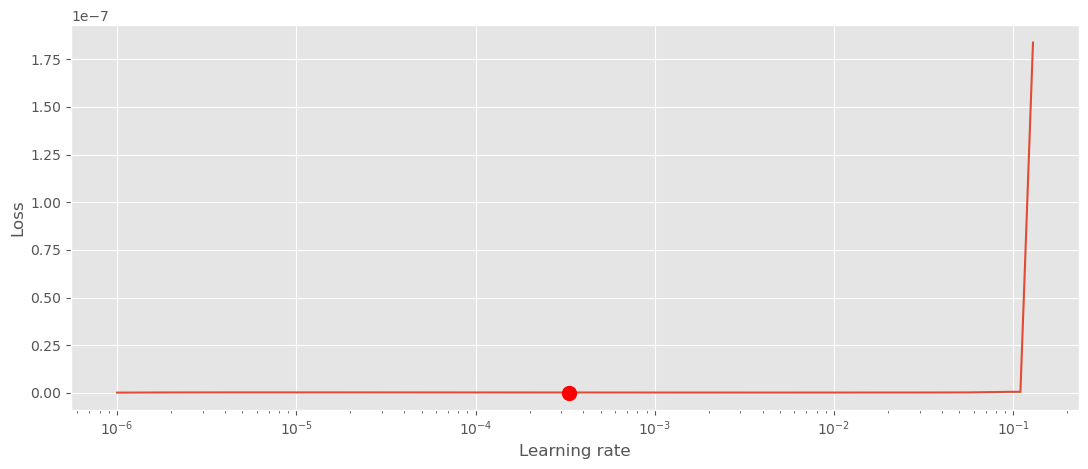

In [29]:
# find optimal learning rate


# learning rate tuning to choose an effective learning rate 
res = Tuner(trainer).lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [30]:
# configure network and trainer
early_stop_callback = EarlyStopping(
    monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min"
)
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=10, # changed from 50 to 10
    accelerator="cpu",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=50,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=2,
    dropout=0.1,
    hidden_continuous_size=8,
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    optimizer="ranger",
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size() / 1e3:.1f}k")

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Number of parameters in network: 19.9k


In [31]:
# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)


   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 0      | train
3  | prescalers                         | ModuleDict                      | 128    | train
4  | static_variable_selection          | VariableSelectionNetwork        | 1.7 K  | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 3.0 K  | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.2 K  | train
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K  | train
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K  

Epoch 9: 100%|██████████| 50/50 [03:26<00:00,  0.24it/s, v_num=0, train_loss_step=1.22e-10, val_loss=9.97e-11, train_loss_epoch=1.29e-10]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 50/50 [03:26<00:00,  0.24it/s, v_num=0, train_loss_step=1.22e-10, val_loss=9.97e-11, train_loss_epoch=1.29e-10]


# Hyperparameter Tuning 

Hyperparameter tuning is done with optuna - which is directly built into pytorch-forecasting. 

In [32]:
# create study
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="optuna_test",
    n_trials=3,
    max_epochs=5,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(8, 128),
    hidden_continuous_size_range=(8, 128),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.001, 0.1),
    dropout_range=(0.1, 0.3),
    trainer_kwargs=dict(limit_train_batches=30),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
)

# save study results - also we can resume tuning at a later point in time
with open("test_study.pkl", "wb") as fout:
    pickle.dump(study, fout)

# show best hyperparameters
print(study.best_trial.params)

[I 2025-05-14 16:00:31,461] A new study created in memory with name: no-name-e9728551-2159-477f-8b1c-4233e8308b9a
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2025-05-14 16:03:00,761] Trial 0 finished with value: 1.296991625210353e-09 and parameters: {'gradient_clip_val': 0.05040410878811946, 'hidden_size': 23, 'dropout': 0.2660027919080969, 'hidden_continuous_size': 11, 'attention_head_size': 4, 'learning_rate': 0.0042255374385107465}. Best is trial 0 with value: 1.296991625210353e-09.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2025-05-14 16:05:01,774] Trial 1 finished with value: 1.296991625210353e-09 and parameters: {'gradient_clip_val': 0.060551797785382916, 'hidden_size': 8, 'dropout': 0.15128327791800966, 'hidden_continuous_size': 8, 'attenti

{'gradient_clip_val': 0.05040410878811946, 'hidden_size': 23, 'dropout': 0.2660027919080969, 'hidden_continuous_size': 11, 'attention_head_size': 4, 'learning_rate': 0.0042255374385107465}


https://www.reddit.com/r/pytorch/comments/1335lwu/pytorch_enable_mps_fallback_help/

# Evaluate Performance 

PyTorch lightning automatically checkpoints training and therefore we can retrieve the best model and load it. 

After training, we can make predictions with predict(). This method allows a very fine-grained control over what it returns so that we can easily match the predictions to the pandas dataframe. 

In [33]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [34]:
# calcualte mean absolute error on validation set
predictions = best_tft.predict(
    val_dataloader, return_y=True, trainer_kwargs=dict(accelerator="cpu")
)
MAE()(predictions.output, predictions.y)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


tensor(2.1983e-10)

In [35]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions = best_tft.predict(
    val_dataloader, mode="raw", return_x=True, trainer_kwargs=dict(accelerator="cpu")
)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


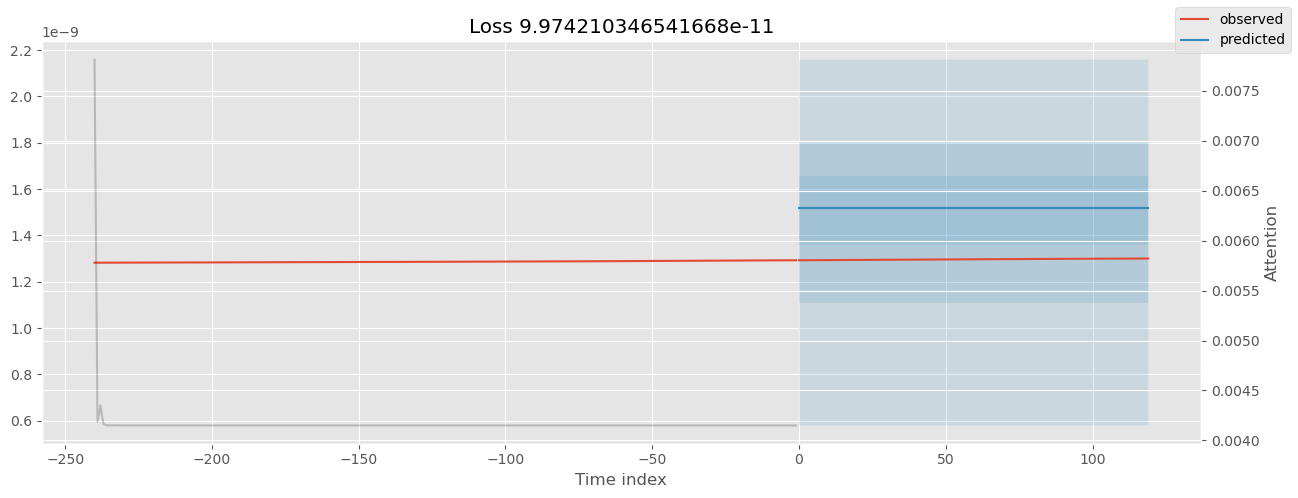

In [38]:
for idx in range(1):  # plot 10 examples
    best_tft.plot_prediction(
        raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=True
    )

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


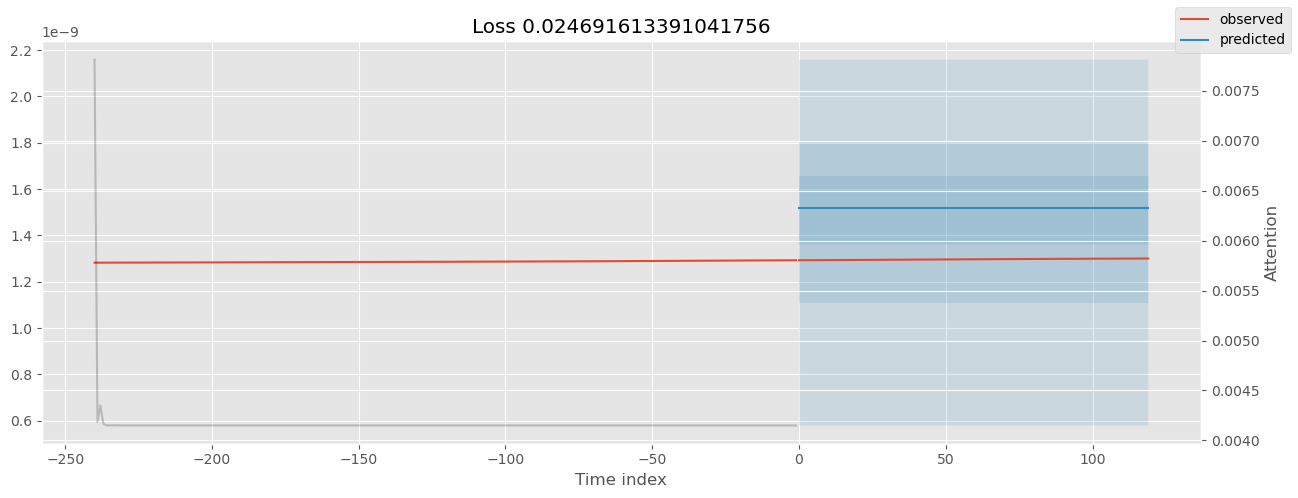

In [40]:
# calcualte metric by which to display
predictions = best_tft.predict(
    val_dataloader, return_y=True, trainer_kwargs=dict(accelerator="cpu")
)
mean_losses = SMAPE(reduction="none").loss(predictions.output, predictions.y[0]).mean(1)
indices = mean_losses.argsort(descending=True)  # sort losses
for idx in range(1):  # plot 10 examples
    best_tft.plot_prediction(
        raw_predictions.x,
        raw_predictions.output,
        idx=indices[idx],
        add_loss_to_title=SMAPE(quantiles=best_tft.loss.quantiles),
    )

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


{'encoder_length': <Figure size 1000x500 with 2 Axes>,
 'processed_correction_value_center': <Figure size 1000x500 with 2 Axes>,
 'processed_correction_value_scale': <Figure size 1000x500 with 2 Axes>,
 'time_idx': <Figure size 1000x500 with 2 Axes>,
 'relative_time_idx': <Figure size 1000x500 with 2 Axes>,
 'processed_broadcast_clock_bias': <Figure size 1000x500 with 2 Axes>,
 'processed_final_clock_bias': <Figure size 1000x500 with 2 Axes>,
 'processed_correction_value': <Figure size 1000x500 with 2 Axes>}

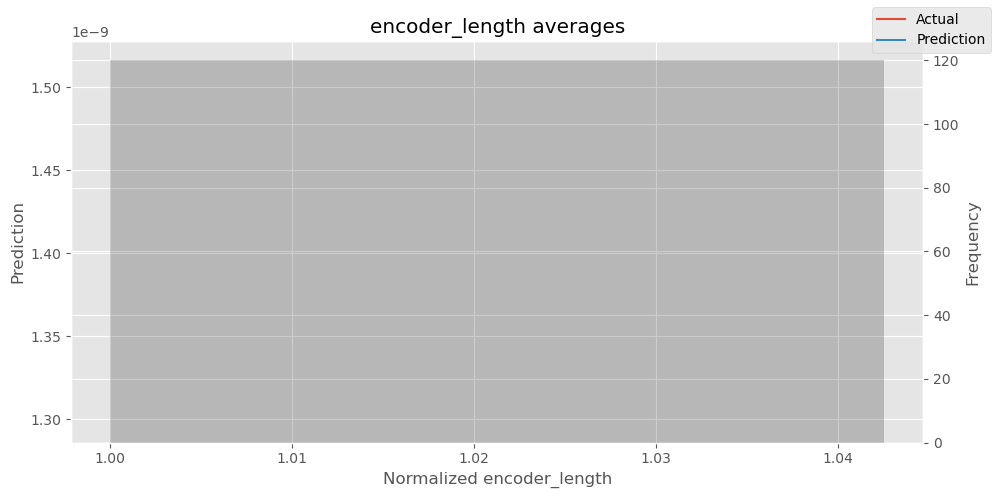

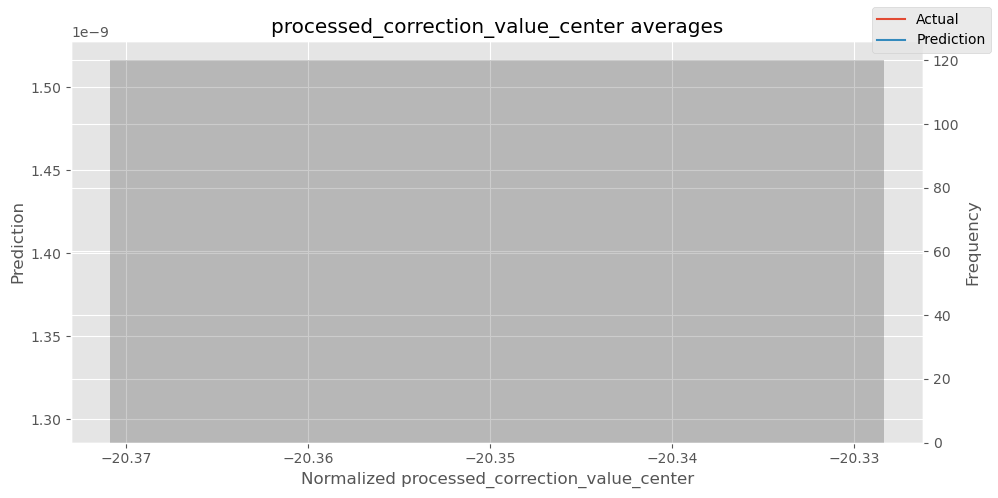

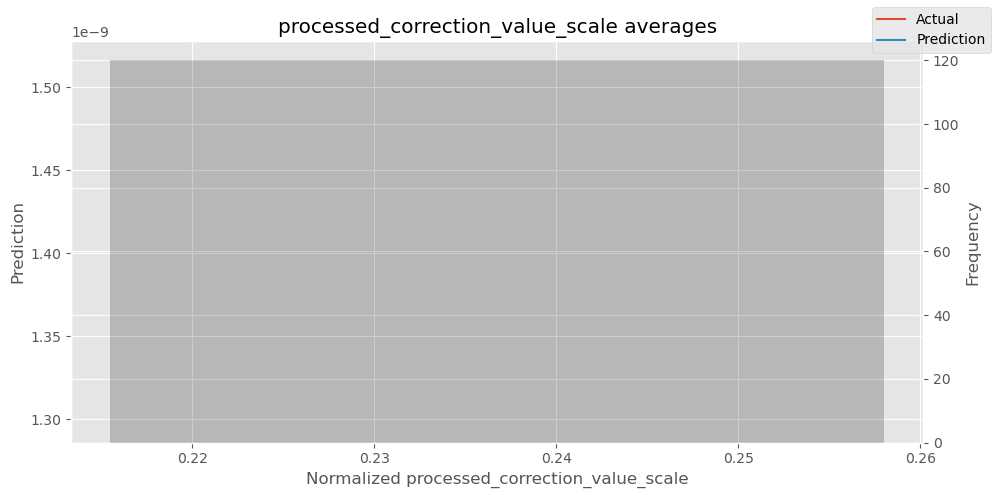

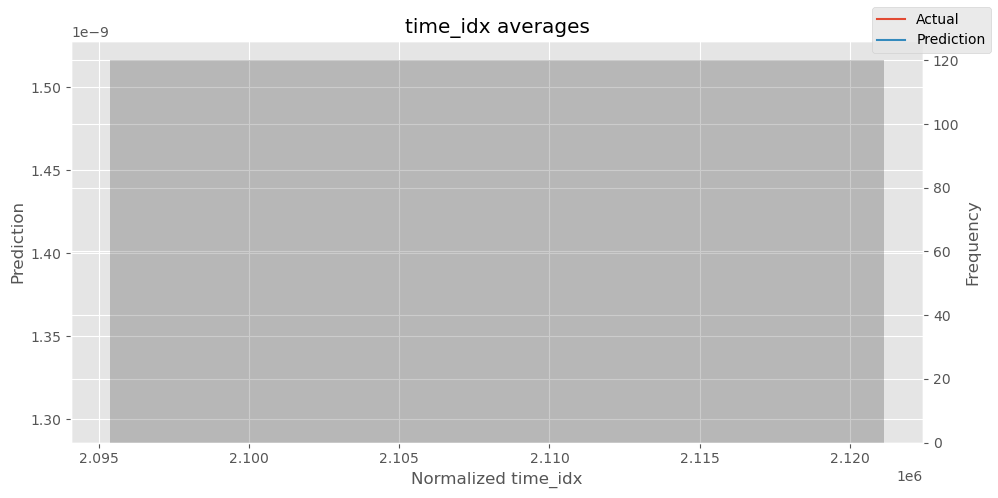

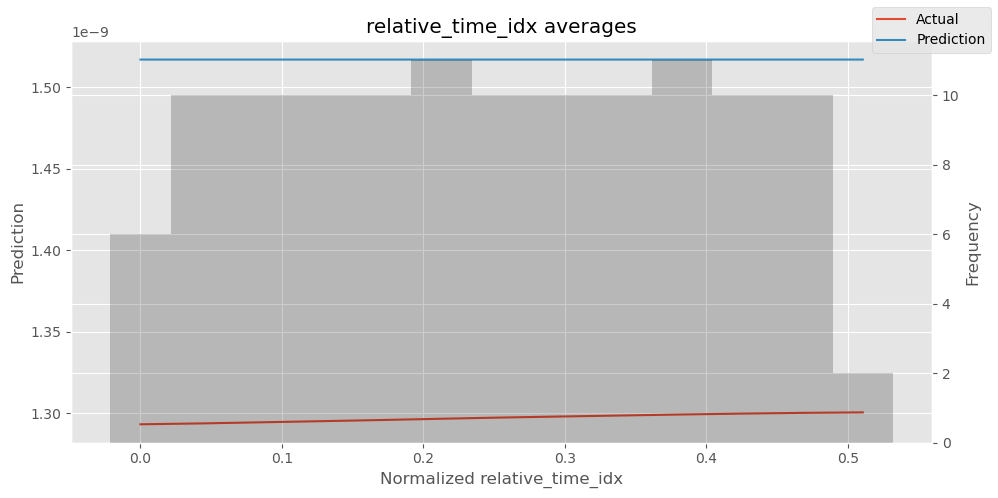

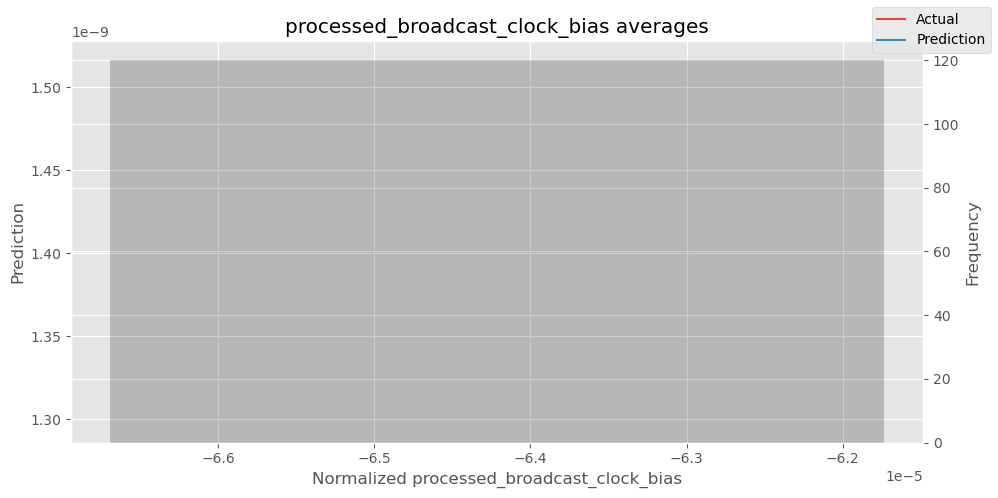

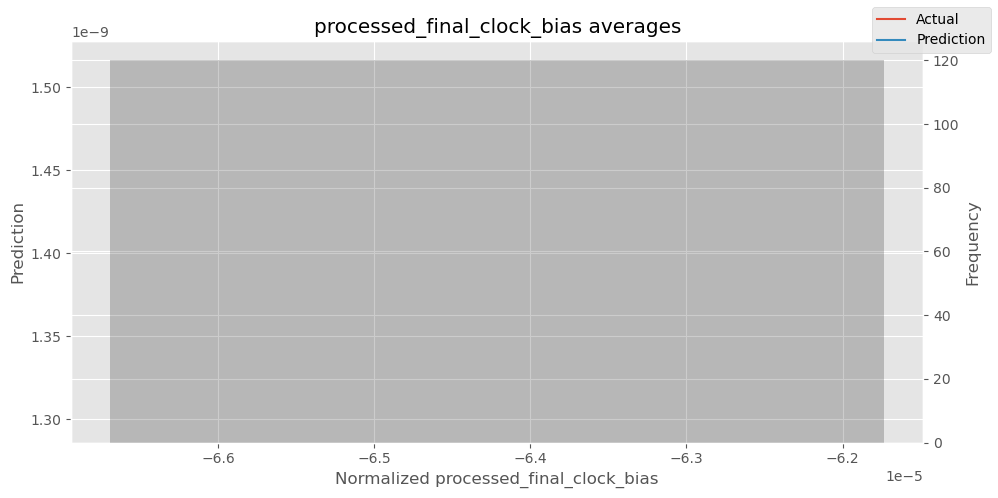

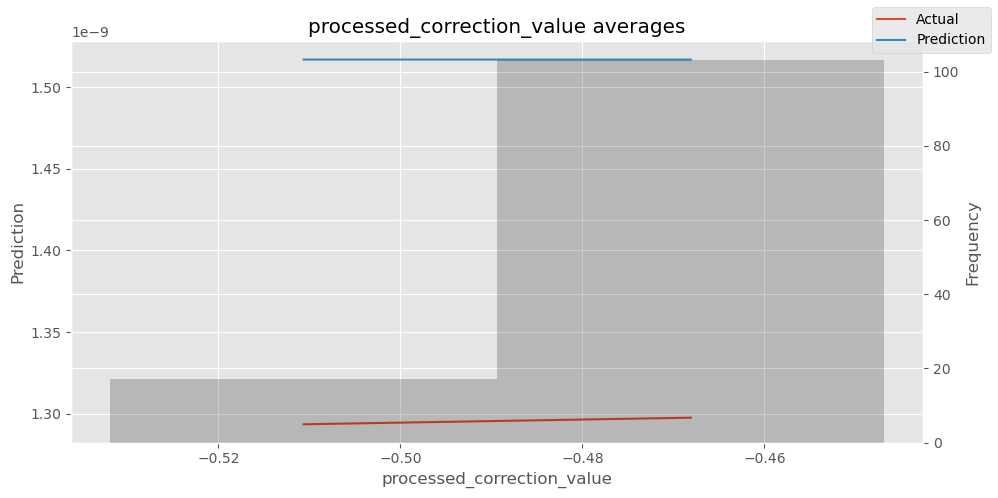

In [41]:
predictions = best_tft.predict(
    val_dataloader, return_x=True, trainer_kwargs=dict(accelerator="cpu")
)
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(
    predictions.x, predictions.output
)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals)

In [42]:
best_tft.predict(
    training.filter(
        lambda x: (x.agency == "Agency_01")
        & (x.sku == "SKU_01")
        & (x.time_idx_first_prediction == 15)
    ),
    mode="quantiles",
    trainer_kwargs=dict(accelerator="cpu"),
)

AttributeError: 'DataFrame' object has no attribute 'agency'

In [ ]:
raw_prediction = best_tft.predict(
    training.filter(
        lambda x: (x.agency == "Agency_01")
        & (x.sku == "SKU_01")
        & (x.time_idx_first_prediction == 15)
    ),
    mode="raw",
    return_x=True,
    trainer_kwargs=dict(accelerator="cpu"),
)
best_tft.plot_prediction(raw_prediction.x, raw_prediction.output, idx=0)

In [ ]:
# select last 24 months from data (max_encoder_length is 24)
encoder_data = data[lambda x: x.time_idx > x.time_idx.max() - max_encoder_length]

# select last known data point and create decoder data from it by repeating it and incrementing the month
# in a real world dataset, we should not just forward fill the covariates but specify them to account
# for changes in special days and prices (which you absolutely should do but we are too lazy here)
last_data = data[lambda x: x.time_idx == x.time_idx.max()]
decoder_data = pd.concat(
    [
        last_data.assign(date=lambda x: x.date + pd.offsets.MonthBegin(i))
        for i in range(1, max_prediction_length + 1)
    ],
    ignore_index=True,
)

# add time index consistent with "data"
decoder_data["time_idx"] = (
    decoder_data["date"].dt.year * 12 + decoder_data["date"].dt.month
)
decoder_data["time_idx"] += (
    encoder_data["time_idx"].max() + 1 - decoder_data["time_idx"].min()
)

# adjust additional time feature(s)
decoder_data["month"] = decoder_data.date.dt.month.astype(str).astype(
    "category"
)  # categories have be strings

# combine encoder and decoder data
new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)

In [ ]:
new_raw_predictions = best_tft.predict(
    new_prediction_data,
    mode="raw",
    return_x=True,
    trainer_kwargs=dict(accelerator="cpu"),
)

for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(
        new_raw_predictions.x,
        new_raw_predictions.output,
        idx=idx,
        show_future_observed=False,
    )

In [ ]:
interpretation = best_tft.interpret_output(raw_predictions.output, reduction="sum")
best_tft.plot_interpretation(interpretation)

In [ ]:
dependency = best_tft.predict_dependency(
    val_dataloader.dataset,
    "discount_in_percent",
    np.linspace(0, 30, 30),
    show_progress_bar=True,
    mode="dataframe",
    trainer_kwargs=dict(accelerator="cpu"),
)

In [ ]:
# plotting median and 25% and 75% percentile
agg_dependency = dependency.groupby("discount_in_percent").normalized_prediction.agg(
    median="median", q25=lambda x: x.quantile(0.25), q75=lambda x: x.quantile(0.75)
)
ax = agg_dependency.plot(y="median")
ax.fill_between(agg_dependency.index, agg_dependency.q25, agg_dependency.q75, alpha=0.3)